# Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries 

In [ ]:
# Mateo Rodriguez
# Zhengji Li

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, sosfilt, sosfreqz, sosfiltfilt
import scipy.fftpack
import sklearn
import librosa
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import minmax_scale
from scipy.integrate import trapz
from scipy.stats import norm
import seaborn as sns
from scipy.signal import stft

np.random.seed(0)

# Split

This function splits the audio data into n equal parts

In [ ]:
def split(song_path, n):
    # Load the audio file and get the sample rate (fs) and the audio data
    fs, data = read(song_path)
    
    # Print the shape of the audio data
    print("Shape of the audio data:", np.shape(data))
    
    # Check if the number of samples in the audio data is even
    # If not, remove the last sample
    if len(data) % 2 != 0:
        data = data[:-1, :]
        
    # Find the optimal number of splits such that the number of samples is divisible by the number of splits
    while True:
        if len(data) % n != 0:
            n = n - 1
        else:
            print("Using", n, "splits")
            break
    
    # Split the audio data into n parts
    chopped = np.array_split(data.astype(np.float32), n)
    
    # Return the sample rate, chopped audio data, and number of splits
    return fs, chopped, n

# Find good peaks in frequency domain

Loop through the peaks and select the first 5 frequency peaks that are not too close to each other

In [ ]:
def plot_spectrogram(fs, spart, i):
    # Initialize an empty list to store the peaks of frequencies for each stereo channel
    gp = []
    # Loop through each stereo channel
    for stereo in range(0,2):
        # Get the data for the current stereo channel
        data = spart[:,stereo]
        # Convert the data to a numpy array of type float
        data = np.array(data, dtype=float)
        # Perform FFT on the data to get the frequency domain representation
        fft_data = fft(data)
        # Get the frequencies corresponding to the FFT result
        frequencies = np.fft.fftfreq(len(data), 1/fs)
        # Get the amplitudes corresponding to the FFT result
        amplitudes = np.abs(fft_data)
        # Filter out the negative frequencies
        mask = frequencies > 0
        frequencies = frequencies[mask]
        amplitudes = amplitudes[mask]
        # Limit the frequency range to 0-10000 Hz
        mask = frequencies < 10000
        frequencies = frequencies[mask]
        amplitudes = amplitudes[mask]
        
        # Convert the frequencies to integers
        frequencies = frequencies.astype(np.int16)
        # Sort the amplitudes in descending order and get the corresponding sorted frequencies
        sort_indices = np.argsort(amplitudes)
        sorted_frequencies = frequencies[sort_indices]
        sorted_values = frequencies[sort_indices][::-1]

        # Define the window size for selecting peaks
        window = 200

        peaks = sorted_values
        goodpeaks = []
        p1,p2,p3,p4,p5 = 0,0,0,0,0
        # Set the first good peak
        p1 = peaks[0]
        # Loop through the peaks and select the first 5 peaks that are not too close to each other
        for number in peaks:
            if number > p1+window or number < p1-window:
                if p2 == 0:
                    p2 = number
                elif number > p2+window or number < p2-window:
                    if p3 == 0:
                        p3 = number
                    elif number > p3+window or number < p3-window:
                        if p4 == 0:
                            p4 = number
                        elif number > p4+window or number < p4-window:
                            if p5 == 0:
                                p5 = number
                            else:
                                break
        goodpeaks = [p1,p2,p3,p4,p5]   
        gp.append(np.sort(goodpeaks))
        print(goodpeaks, np.sort(goodpeaks))
    return gp

# Butterworth filters

Defining the butterworth filters

In [ ]:
#bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

#lowpass
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False, output='sos')

def butter_lowpass_filter(data, cutoff, fs, order=5):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

#highpass
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False, output='sos')

def butter_highpass_filter(data, cutoff, fs, order=5):
    sos = butter_highpass(cutoff, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def lowpassf(x,lowpass_l,lvl):
    yl = butter_lowpass_filter(x, lowpass_l, fs, order=lvl)
    return yl 
def bandpassf(x,lowcut, highcut,lvl):
    yb = butter_bandpass_filter(x, lowcut, highcut, fs, order=lvl)
    return yb
def highpassf(x,highpass_h,lvl):
    yh = butter_highpass_filter(x, highpass_h, fs, order=lvl)
    return yh

def filtering(fs, part, peaks, mono, i):
    window = 200
    lowpass_l = peaks[0]+window
    highpass_h = peaks[3]-window
    lowcut = peaks[1]-window
    highcut = peaks[2]+window
  
    lvl = 6
    fs = 44100.0

    if mono == 'L':
        s1 = part[:,1]
    else: 
        s1 = part[:,0]

    
    lx = lowpassf(s1,lowpass_l,lvl)
    lx /= np.max(np.abs(lx),axis=0)
    mx = bandpassf(s1,lowcut,highcut,lvl)
    mx /= np.max(np.abs(mx),axis=0)
    hx = highpassf(s1,highpass_h,lvl)
    hx /= np.max(np.abs(hx),axis=0)

    plt.figure(figsize=(30,12),dpi=90)
    fft_array = np.fft.fft(s1)
    fft_array = fft_array[:len(fft_array)//2]
    plt.subplot(4,1,1)
    plt.plot(np.abs(fft_array))
    fft_array = np.fft.fft(lx)
    fft_array = fft_array[:len(fft_array)//2]
    plt.subplot(4,1,2)
    plt.plot(np.abs(fft_array))

    fft_array = np.fft.fft(mx)
    fft_array = fft_array[:len(fft_array)//2]
    plt.subplot(4,1,3)
    plt.plot(np.abs(fft_array))

    fft_array = np.fft.fft(hx)
    fft_array = fft_array[:len(fft_array)//2]
    plt.subplot(4,1,4)
    plt.plot(np.abs(fft_array))
    plt.show()

    print(mono, i )
    write('/content/drive/MyDrive/Signals/ICA example/Filtered/bass{}'.format(i)+mono+'.wav', int(fs), lx.astype(np.float32))
    write('/content/drive/MyDrive/Signals/ICA example/Filtered/mid{}'.format(i)+mono+'.wav', int(fs), mx.astype(np.float32))
    write('/content/drive/MyDrive/Signals/ICA example/Filtered/high{}'.format(i)+mono+'.wav', int(fs), hx.astype(np.float32))

# ICA

separate the mixed audio signals into individual sources. The inputs are audio files that are pre-filtered into three frequency bands: bass, mid, and high.

In [ ]:
def mix(sources):
    copy = sources.copy()
    sources = np.array(sources)
    
    for i in range(len(sources)):
        # Normalize each source signal so its maximum absolute value is 1
        sources[i] /= np.max(np.abs(sources[i]), axis=0)
        # Mix the source signals with a weighting factor
        copy[i] = (np.sum(sources, axis=0) * 0.01 + sources[i] * 30) / (len(sources) + 35)
        # Normalize the mixed signals
        copy[i] /= np.max(np.abs(copy[i]), axis=0)

    return np.c_[[source for source in copy]]

def ica(x):
    try:
        ica = FastICA(n_components=len(x), random_state=0, whiten='arbitrary-variance', fun='cube')
        S_ = ica.fit_transform(np.transpose(x))
    except Exception as e:
        print('Cube function failed, attempting with exponential',e)
        # If the "cube" function is not suitable, use the "exp" function instead
        ica = FastICA(n_components=len(x), random_state=0, whiten='arbitrary-variance', fun='exp')
        S_ = ica.fit_transform(np.transpose(x))

    return S_

def ICArun(sampling_rate, i, s_file, mx, SPLITNUM):
    
    # initialize the list to store the stereo signals
    ss = []
    mono = 'L'
    # loop through two times to read the left and right stereo signals
    for qwop in range(0,2):
        ss.append(read('/content/drive/MyDrive/Signals/ICA example/Filtered/bass{}'.format(i)+mono+'.wav')[1].astype(np.float32))
        ss.append(read('/content/drive/MyDrive/Signals/ICA example/Filtered/mid{}'.format(i)+mono+'.wav')[1].astype(np.float32))
        ss.append(read('/content/drive/MyDrive/Signals/ICA example/Filtered/high{}'.format(i)+mono+'.wav')[1].astype(np.float32))
        # switch to the right stereo signal
        mono = 'R'

    # load the orginal song
    _, sog,_ = split(s_file,SPLITNUM)
    # print('here', len(ss), np.shape(ss), np.shape(sog), np.shape(sog[i]), np.shape(sog[i][:,0]),  np.shape(ss[0]))
    for j in range(0,int(len(ss)/2)): #each stereo side of each filter file i.e. 3 per side = 6 tot
        if mx:
            # mix the signals
            x = mix([ss[j], sog[i][:,1], ss[j+3], sog[i][:,0]])
        else:
            # stack the signals
            x = np.array([ss[j], sog[i][:,1], ss[j+3]], sog[i][:,0])
        
        # write the mixed signals to files
        write('/content/drive/MyDrive/Signals/ICA example/mix1.wav', fs, x[0].astype(np.float32))
        write('/content/drive/MyDrive/Signals/ICA example/mix2.wav', fs, x[1].astype(np.float32))

        # perform ICA on the mixed signals
        S = np.transpose(ica(x))
        
        # loop through each output of ICA
        for qwop in range(0,4): # 4 outputs for filtered left and right, and original left and right
            # save the separated signals to files
            # j->bass,mid,high / i->split / qwop->each file for each frequency level
            write('/content/drive/MyDrive/Signals/ICA example/Separated/s{}_predicted{}_{}.wav'.format(j+1,i,qwop), sampling_rate, S[qwop].astype(np.float32))
        # reset the values of ss[j] and ss[j+3]
        ss[j], ss[j+3] = 0,0
        S=[]

# Audio Merging

This code merges audio data from the splits, processes it by computing the mean of the 2 lowest frequency peaks (for bass), the mean of 3 mid peaks (for mid), the mean of 2 top peaks (for high) checks for outliers, replacing the outliers with a dampened version of the song, normalizes the audio data and clips it between -0.95 and 0.95, and writes the final audio data to a file.

In [ ]:
def merge(sampling_rate, i, SPLITNUM, s_file):
    z = 0
    for k in range(0, 4):
        final = []
        peaks = []

        # Read and find lowest peaks mean of the bass splits
        for j in range(0, i):
            fs, b = read('/content/drive/MyDrive/Signals/ICA example/StereoSorted/s1_predicted{}_{}.wav'.format(j, k))            
            final.append(b)
            peaks.append(np.mean(peakf(fs, b)[0:2])) # Mean of the 2 lowest frequency peaks
        
        # Check for outliers and replace the song parts if needed, and merge the splits
        if SPLITNUM > 1:
            outlier_ind = remove_outliers(peaks, 0.2)
            final = replace(np.array(final), outlier_ind, SPLITNUM, s_file)
        else:
            final = np.concatenate(final)
        
        # Normalize and clip the final audio
        final /= np.max(np.abs(final), axis=0)
        final = np.clip(final, -0.95, 0.95)
        write('/content/drive/MyDrive/Signals/ICA example/Final/final1_{}.wav'.format(z), sampling_rate, final.astype(np.float32))
        z += 1
        final = []
        peaks = []

        # Read and find mid peaks mean of the mid splits
        for j in range(0, i):
            fs, b = read('/content/drive/MyDrive/Signals/ICA example/StereoSorted/s2_predicted{}_{}.wav'.format(j, k))            
            final.append(b)
            peaks.append(np.mean(peakf(fs, b)[1:-1])) # Mean of the 3 mid frequency peaks
        
        # Check for outliers and replace the song parts if needed, and merge the splits
        if SPLITNUM > 1:
            outlier_ind = remove_outliers(peaks, 0.2)
            final = replace(np.array(final), outlier_ind, SPLITNUM, s_file)
        else:
            final = np.concatenate(final)
        
        # Normalize and clip the final audio
        final /= np.max(np.abs(final), axis=0)
        final = np.clip(final, -0.95, 0.95)
        write('/content/drive/MyDrive/Signals/ICA example/Final/final2_{}.wav'.format(z), sampling_rate, final.astype(np.float32))
        z += 1
        final = []
        peaks = []

        # Read and find high peaks mean of the high splits
        for j in range(0, i):
            fs, b = read('/content/drive/MyDrive/Signals/ICA example/StereoSorted/s3_predicted{}_{}.wav'.format(j, k))            
            final.append(b)
            peaks.append(np.mean(peakf(fs, b)[-2:])) # Mean of the 2 highest frequency peaks
        
        # Check for outliers and replace, and merge
        if SPLITNUM >1:
            #check for outliers
            outlier_ind = remove_outliers(peaks,0.2)
            #replace the song parts with a dampened version of the song
            final = replace(np.array(final), outlier_ind, SPLITNUM, s_file)
        else:
            final = np.concatenate(final)

        print(final.max(), final.min())
        final /= np.max(np.abs(final),axis=0)
        final = np.clip(final, -0.95, 0.95)
        print(final.max(), final.min())
        write('/content/drive/MyDrive/Signals/ICA example/Final/final3_{}.wav'.format(z), sampling_rate, final.astype(np.float32))
        z+=1
        final = []        

# multi-step audio processing pipeline

Performing PCA on audio data.
Plotting a spectrogram and detecting peaks in the audio signal
Filtering the audio signal based on the peaks detected in the previous step
Applying ICA (Independent Component Analysis) to separate the sources of the audio signal
Sorting the independent components obtained in the previous step.

In [ ]:
def run(fs, chopped, s_file, SPLITNUM):
    i = 0
    for part in chopped:
        part = PCArun(part)
        peaks = plot_spectrogram(fs, part, i)
        mono = 'L'
        for side in peaks:
            filtering(fs, part, side, mono, i)
            # alternate between L and R channel
            mono = 'R'
        ICArun(fs, i, s_file, True, SPLITNUM)
        sortica(i)
        i += 1
    return i

# PCA

In [ ]:
def PCArun(data):
    # Perform PCA on the audio data format: (length, channels)
    pca = PCA(n_components=len(data[1]))
    
    pca.fit(data)
    # Transform the audio data using the PCA model
    pca_data = pca.transform(data)
    pca_data /= np.max(np.abs(pca_data),axis=0)
    return pca_data

# Independent Component Analysis

The code is divided into three functions: peakf, partfinder, and sortica. The first function, peakf, calculates the FFT of an audio signal and extracts the top 5 frequencies. The second function, partfinder, sorts the audio signals based on their area under the curve of the FFT and saves them in sorted order. The third function, sortica, reads the separated audio signals and applies the peakf and partfinder functions to each set of signals.

In [ ]:
def peakf(fs, data):
    # Convert data to float and compute the FFT
    data = np.array(data, dtype=float)
    fft_data = fft(data)
    
    # Compute the frequencies and amplitudes from the FFT data
    frequencies = np.fft.fftfreq(len(data), 1/fs)
    amplitudes = np.abs(fft_data)
    
    # Mask to select only positive frequencies
    mask = frequencies > 0
    frequencies = frequencies[mask]
    amplitudes = amplitudes[mask]
    
    # Mask to select only frequencies less than 10000
    mask = frequencies < 10000
    frequencies = frequencies[mask]
    amplitudes = amplitudes[mask]
    
    # Round the frequencies to integers
    frequencies = frequencies.astype(np.int16)
    
    # Sort the amplitudes and corresponding frequencies in decreasing order
    sort_indices = np.argsort(amplitudes)
    sorted_frequencies = frequencies[sort_indices]
    sorted_values = frequencies[sort_indices][::-1]
    peaks = sorted_values
    
    # Keep only the five largest peaks
    goodpeaks = []
    p1, p2, p3, p4, p5 = 0, 0, 0, 0, 0
    window = 200
    p1 = peaks[0]
    for number in peaks:
        if number > p1 + window or number < p1 - window:
            if p2 == 0:
                p2 = number
            elif number > p2 + window or number < p2 - window:
                if p3 == 0:
                    p3 = number
                elif number > p3 + window or number < p3 - window:
                    if p4 == 0:
                        p4 = number
                    elif number > p4 + window or number < p4 -window:
                        if p5 == 0:
                            p5 = number
                        else:
                            break
    goodpeaks = [p1, p2, p3, p4, p5]
    
    # Sort the good peaks and return the result
    return np.sort(goodpeaks)


def partfinder(audio, j, i):
    # List to store the mean values of each audio
    means = []

    # Compute the mean value of each audio using the FFT
    for z in range(len(audio)):
        spect = np.fft.fft(audio[z])
        # Take only the first half of the FFT output and calculate the absolute value
        spect = abs(spect[:len(spect)//2])
        # Normalize the values between 0 and 1
        spect = spect / spect.max()
        # Add the sum of the values to the means list
        means.append(np.sum(spect))
    
    # Sort the indices of the audio signals based on their mean values
    sorted_indices = np.argsort(means)
    
    # Convert the audio and means lists to numpy arrays
    audio = np.array(audio)
    means = np.array(means)

    # Save the sorted audio signals and plot their FFTs
    for k in range(len(sorted_indices)):
        # Load the kth sorted audio signal
        qwop = sorted_indices[k]
        fs, song = read(f'/content/drive/MyDrive/Signals/ICA example/Separated/s{j+1}_predicted{i}_{qwop}.wav')
        # Save the kth sorted audio signal to a specified directory
        write(f'/content/drive/MyDrive/Signals/ICA example/StereoSorted/s{j+1}_predicted{i}_{k}.wav', fs, song)
        # Create a plot of the FFT of the kth sorted audio signal
        plt.figure()
        plt.title(f'LMH {j+1} / Split {i} / Sorted {k}')
        fft_array = np.fft.fft(song)
        fft_array = fft_array[:len(fft_array)//2]
        plt.plot(np.abs(fft_array))

def sortica(i):
    # List to store audio data
    files = []

    # Loop through 3 levels of frequency files and 4 ICA outputs
    for j in range(0,3):
        for qwop in range(0,4):
            fs, aud = read('/content/drive/MyDrive/Signals/ICA example/Separated/s{}_predicted{}_{}.wav'.format(j+1,i,qwop))
            files.append(aud)

    # Split list into 3 separate lists (one for each frequency leve1)
    files = [files[0:4], files[4:8], files[8:]]

    # Loop through each frequency level
    for j in range(0,3):
        partfinder(files[j],j,i)

# Removing Outliers from Data Points

This code uses the scipy library and seaborn library in Python to remove outliers from a given set of data points. The code calculates the mean and standard deviation of the data points and uses these values to fit a normal distribution to the data. A threshold value is specified and the probability density function (pdf) of each data point is calculated and compared to the threshold value. Any data points lower than the threshold value are considered outliers and their index values are returned as a list. Finally, a scatter plot of the data points is displayed along with a plot of the normal distribution fit to visualize the outliers in the data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

def remove_outliers(data, threshold):
    # Calculate mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the probability density function for the data points
    pdf = norm.pdf(data, mean, std)
    threshold = threshold * pdf.max()
    
    # Find the values with probability less than the threshold
    unacceptable_indexes = [i for i, d in enumerate(data) if pdf[i] < threshold]
    
    # Plotting the data points and normal distribution fit
    sns.scatterplot(x=data, y=0)
    mu, std = norm.fit(data)
    x_axis = np.linspace(min(data), max(data), 100)
    pdf = norm.pdf(x_axis, mu, std)
    plt.plot(x_axis, pdf, label='Normal Distribution')
    plt.xlabel('Data Point Index')
    plt.ylabel('Data Point Value')
    plt.title('Data Points and Normal Distribution Fit')
    plt.legend()
    plt.show()
    
    return unacceptable_indexes

# Replace Outliers in Audio Signal

In [ ]:
def replace(song, outliers_ind, SPLITNUM, s_file):
    # Load the audio file and split it into `SPLITNUM` segments
    fs, chopped,_ = split(s_file, SPLITNUM)
    
    # Average each segment along the channel axis (if the audio file has multiple channels)
    chopped = np.mean(chopped, axis=-1) / 2
    
    # Normalize the amplitude of each segment
    for i in range(0, SPLITNUM):
        chopped[i] /= np.max(np.abs(chopped[i]), axis=0)
        
    # Replace the `outliers_ind` segments with the normalized segments scaled by a factor of 0.005
    song[outliers_ind] = chopped[outliers_ind] * 0.005
    
    # Print a message indicating which segments were replaced
    print('Replaced split:', outliers_ind)
    
    # Concatenate all segments to form the final audio signal
    return np.concatenate(song)

# RUN

Shape of the audio data: (13635584, 2)
Using 1 splits
(1, 13635584, 2)
[88, 298, 530, 796, 1069] [  88  298  530  796 1069]
[357, 88, 596, 1069, 1425] [  88  357  596 1069 1425]


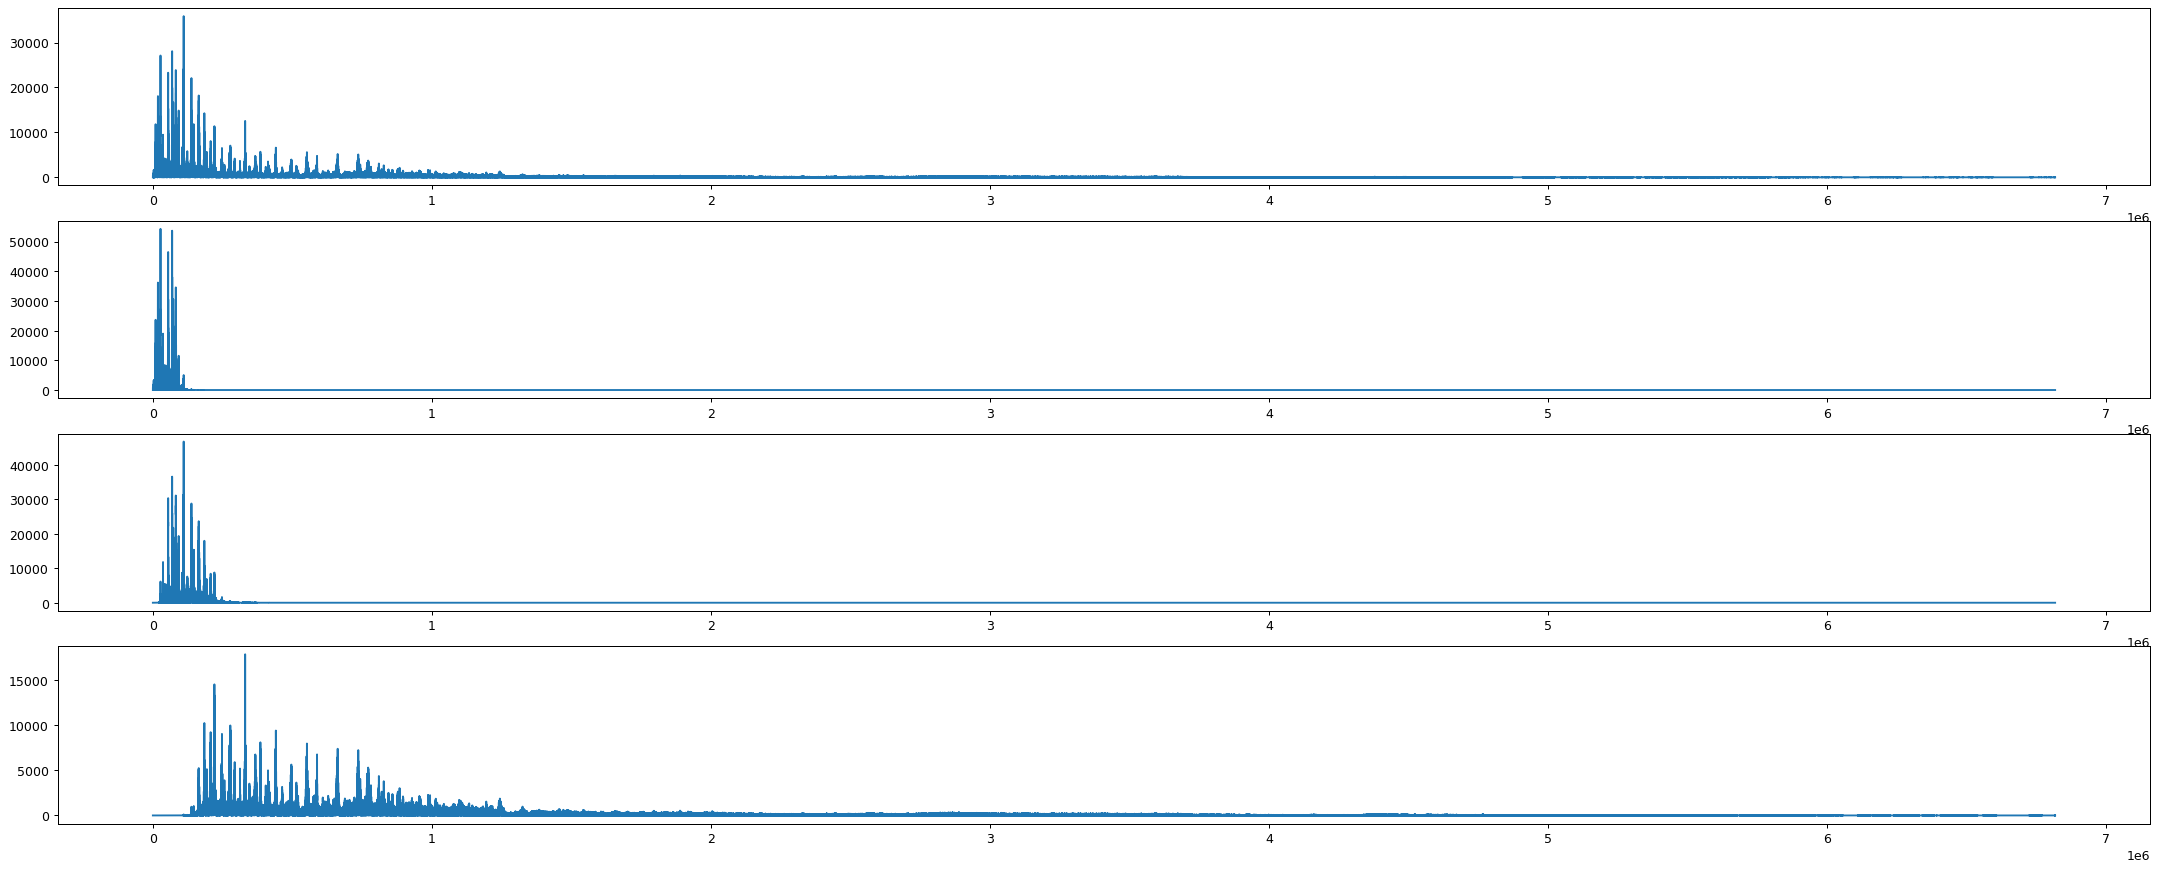

L 0


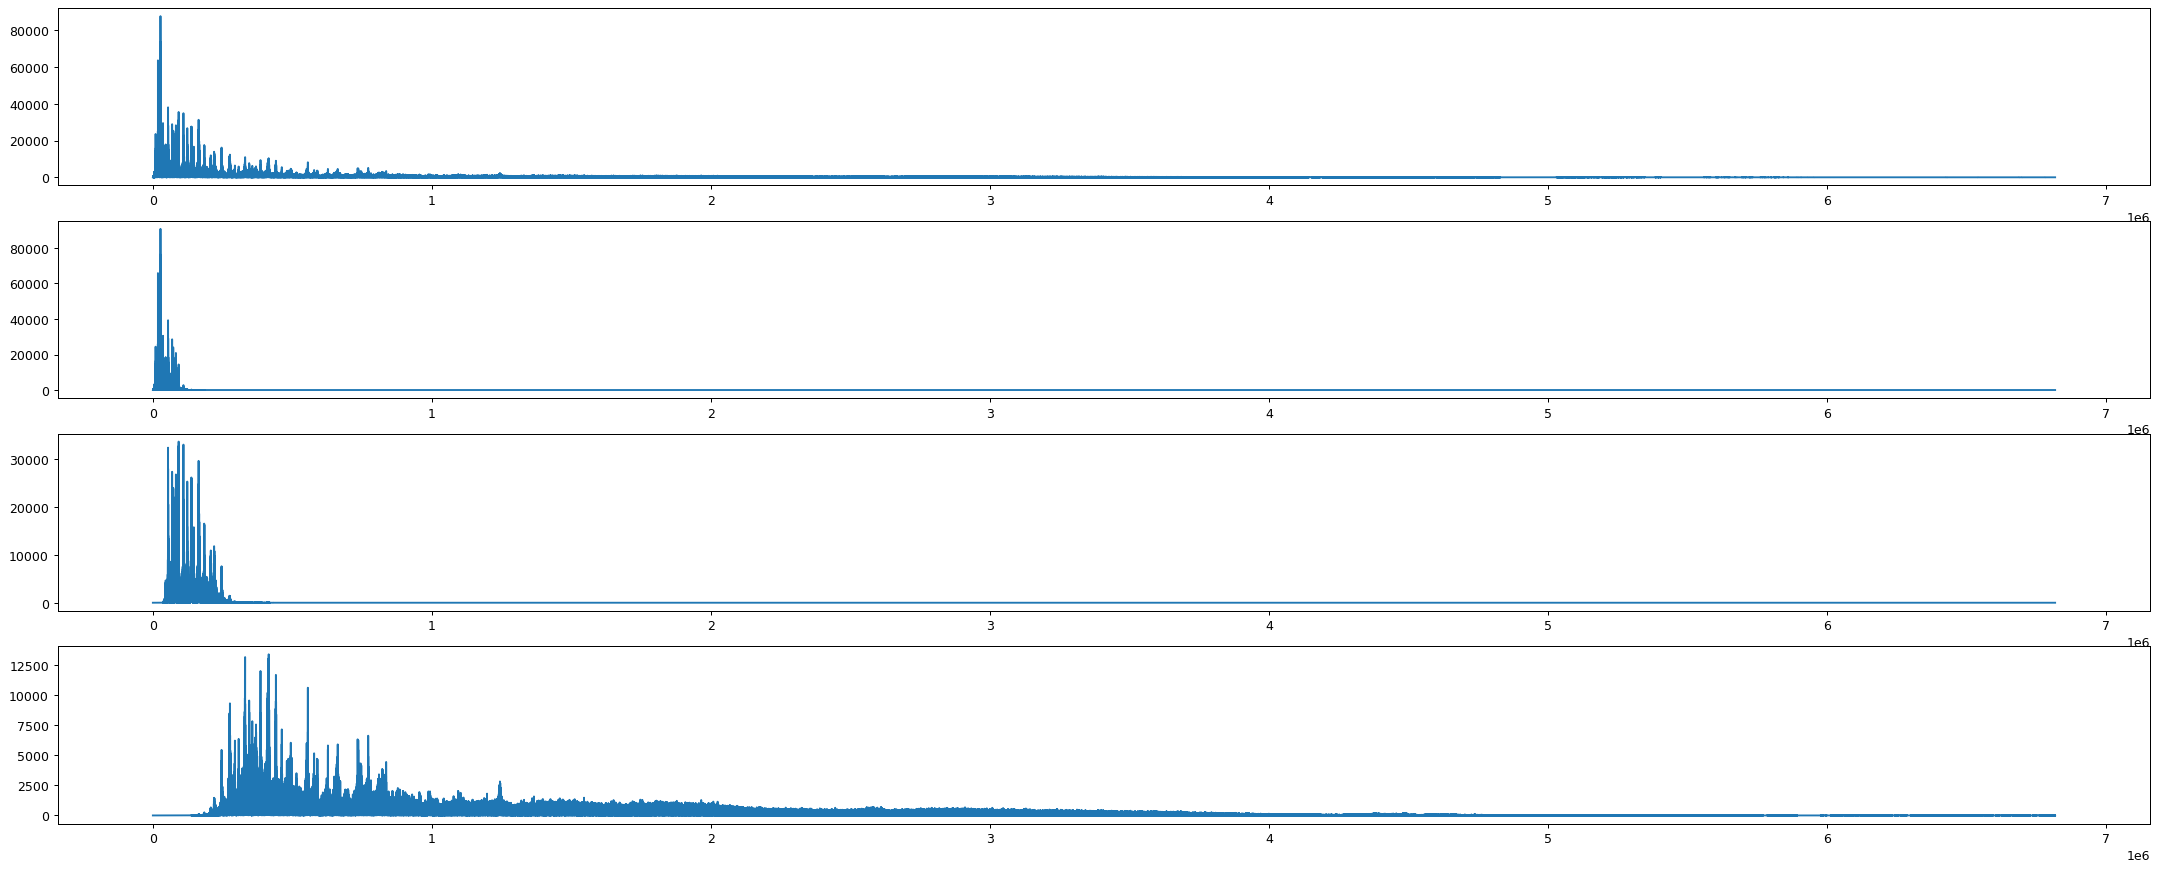

R 0
Shape of the audio data: (13635584, 2)
Using 1 splits
0.001570868 -0.0014827172
0.95 -0.9438841
0.0016149072 -0.0016630653
0.95 -0.95
0.003140388 -0.0033212032
0.94555736 -0.95
0.0025057576 -0.0025303762
0.95 -0.95


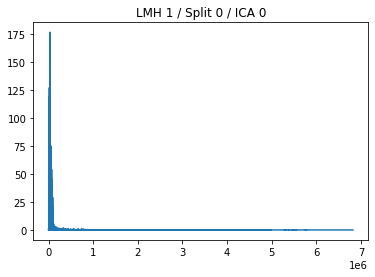

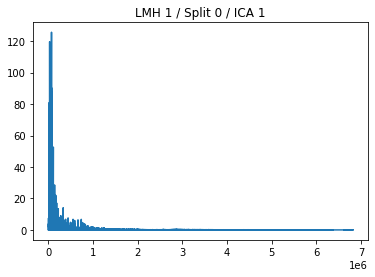

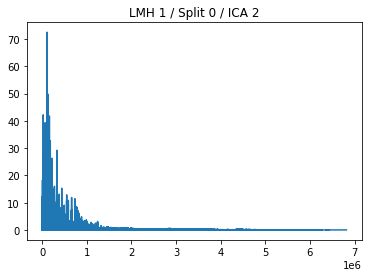

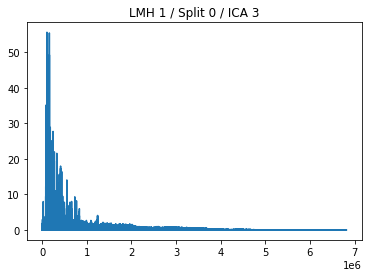

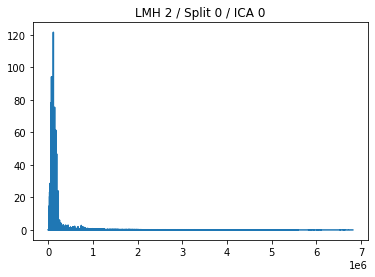

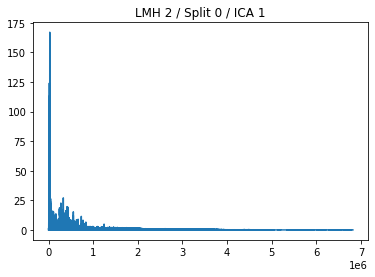

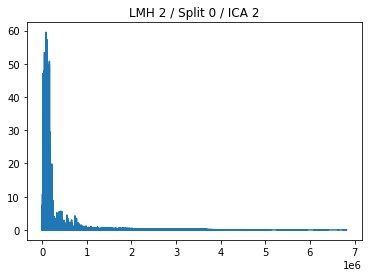

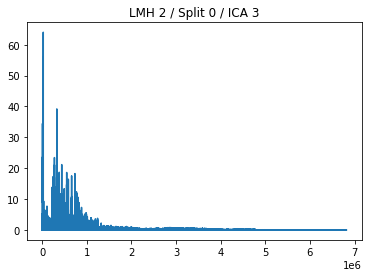

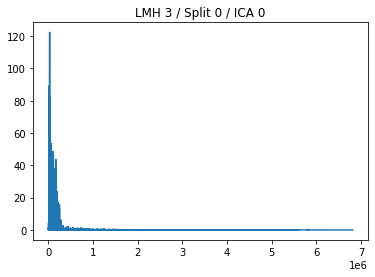

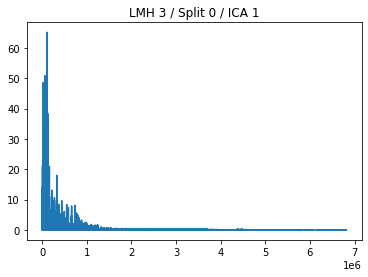

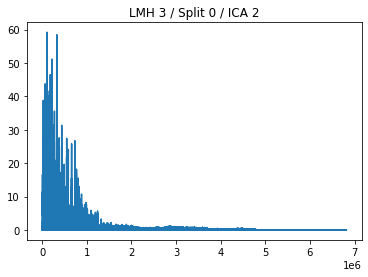

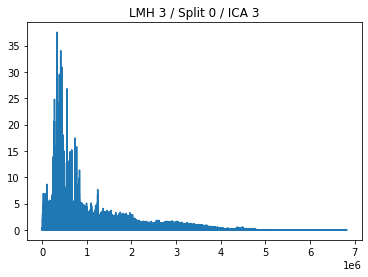

In [ ]:
s_file = "/content/drive/MyDrive/Signals/adele.wav"
SPLITNUM = 1

fs, chopped,SPLITNUM = split(s_file,SPLITNUM)
print(np.shape(chopped))
i = run(fs, chopped, s_file,SPLITNUM)


merge(fs, i, SPLITNUM, s_file)